# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [2]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
# DATA_PATH = '/home/pepe/Documents/github_repos/datasets/asl_data'
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [4]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
# check shapes
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


(27455, 784)
(27455,)
(7172, 784)
(7172,)


In [6]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    if shuffle:
        idx = np.random.permutation(len(x))
        x = x[idx]
        y = y[idx]
    split = int(len(x) * pct)
    return x[:split], y[:split], x[split:], y[split:]

In [7]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [8]:
# check shapes and types
print('x_train shape:', x_train.shape, 'type:', x_train.dtype)
print('y_train shape:', y_train.shape, 'type:', y_train.dtype)
print('x_val shape:', x_val.shape, 'type:', x_val.dtype)
print('y_val shape:', y_val.shape, 'type:', y_val.dtype)
print('x_test shape:', x_test.shape, 'type:', x_test.dtype)
print('y_test shape:', y_test.shape, 'type:', y_test.dtype)


x_train shape: (27455, 784) type: float32
y_train shape: (27455,) type: int64
x_val shape: (3586, 784) type: float32
y_val shape: (3586,) type: int64
x_test shape: (3586, 784) type: float32
y_test shape: (3586,) type: int64


In [9]:
### The following
# remove j and z from the alphabet because they are extensions of other letters
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

In [10]:
def normalise(x_mean, x_std, x_data):
    """
    Normalise the data by subtracting the mean and dividing by the standard deviation.
    x_mean: mean of the data
    x_std: standard deviation of the data
    x_data: data to be normalised
    """
    return (x_data - x_mean) / x_std


In [11]:
x_mean = np.mean(x_train)
x_std = np.std(x_train)

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)


In [12]:
x_train.mean(), x_train.std()


(3.6268384e-06, 0.99999946)

In [13]:
x_val.mean(), x_val.std()


(0.016213331, 1.0035003)

In [14]:
x_test.mean(), x_test.std()

(0.03629113, 1.0075918)

### Graficar muestras

In [15]:
def plot_letter(image):
    """
    Plot the image of a letter.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

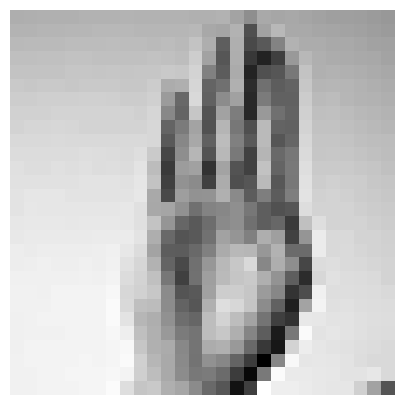

The label is b


In [16]:
# plot a random letter
random_index = np.random.randint(len(y_test))
plot_letter(x_test[random_index])
print(f'The label is {alphabet[y_test[random_index]]}')


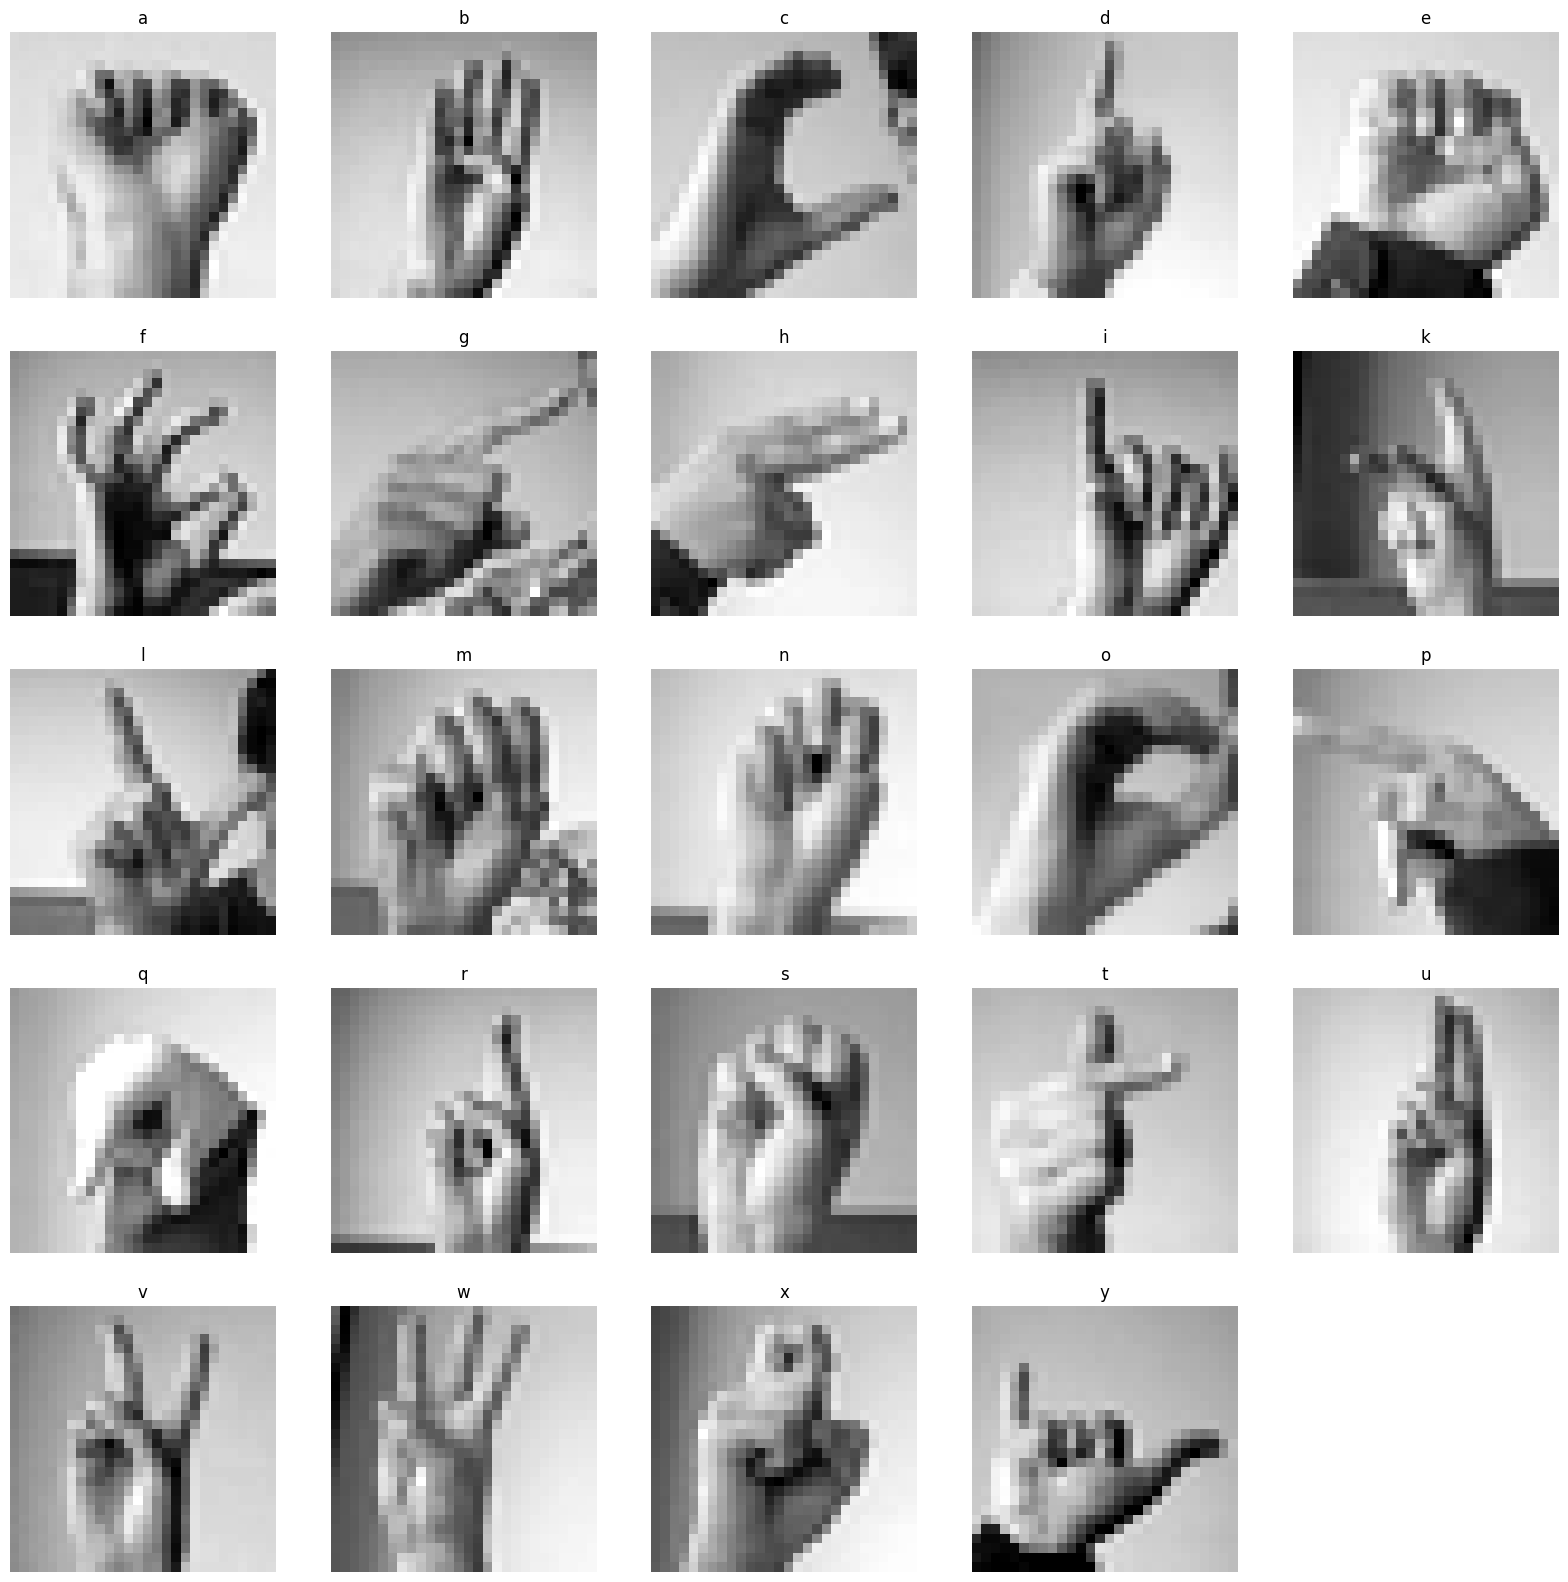

In [17]:
# plot all the letters in the alphabet

plt.figure(figsize=(20, 20))
for i in range(len(alphabet)):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[y_train == i][0].reshape(28, 28), cmap='gray')
    plt.title(f'{alphabet[i]}')
    plt.axis('off')


### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

In [18]:
# seed for reproducibility
np.random.seed(42)

#### Mini batches

In [19]:
def create_minibatches(size, x, y, shuffle=True):
  """
  Create minibatches of the data for the training process.
  size: size of the minibatches
  x: data
  y: labels
  shuffle: shuffle the data before creating the minibatches
  """

  # assert that the data and labels have the same length
  assert len(x) == len(y), 'data and labels have different lengths'
  total_data = x.shape[0]
  if shuffle:
    idxs = np.arange(total_data)
    np.random.shuffle(idxs)
    x = x[idxs]
    y = y[idxs]
  
  # create the minibatches
  return ((x[i:i+size], y[i:i+size]) for i in range(0, total_data, size))

In [20]:
# test the function
mb_size = 128
mb_train = create_minibatches(mb_size, x_train, y_train)

print('Number of minibatches:', len(x_train)/mb_size)
print('Size of minibatch X:', mb_train.__next__()[0].shape)
print('Size of minibatch Y:', mb_train.__next__()[1].shape)


Number of minibatches: 214.4921875
Size of minibatch X: (128, 784)
Size of minibatch Y: (128,)


## Nuestra clase Linear, ReLU y Sequential

In [21]:
class np_tensor(np.ndarray): pass

###  Clase Linear

In [22]:
class Linear():
  """
  Class for a linear layer.
  """

  def __init__(self, input_size, output_size):
    """
    Init layer using Kaiming He initialization.
    input_size: number of input neurons
    output_size: number of output neurons
    """
    self.weights = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
    self.bias = (np.zeros((output_size, 1))).view(np_tensor)

  def __call__(self, X):
    """
    Forward pass, dot product of weights and input plus bias.
    X: input data    
    """
    return self.weights @ X + self.bias
  
  def backward(self, X, Z):
    """
    Backward pass.
    x: input data
    grad: gradient from the previous layer
    """
    # save the gradient on the gradient attribute
    X.grad = self.weights.T @ Z.grad
    self.weights.grad = Z.grad @ X.T
    self.bias.grad = np.sum(Z.grad, axis=1, keepdims=True)

### Clase ReLU

In [23]:
class ReLU():
  """
  Class for a ReLU activation layer
  """

  def __call__(self, Z):
    """
    Forward pass.
    Z: input data
    """
    return np.maximum(0, Z)
  
  def backward(self, Z, A):
    """
    Backward pass.
    Z: input data
    A: output of the forward pass
    """
    Z.grad = A.grad.copy()
    Z.grad[Z <= 0] = 0

### Clase Sequential

In [24]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.weights = layer.weights - learning_rate * layer.weights.grad
            layer.bias = layer.bias - learning_rate * layer.bias.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))       
        

### Cost Function

In [25]:
def softmaxXEntropy(x, y):
  """
  Softmax and cross entropy loss.
  x: input data
  y: labels
  """

  batch_size = x.shape[1]
  exp_scores = np.exp(x)
  probs = exp_scores / exp_scores.sum(axis=0)
  preds = probs.copy()

  # cost
  y_hat = probs[y, np.arange(batch_size)]
  cost = np.sum(-np.log(y_hat)) / batch_size

  # gradient calculation
  probs[y, np.arange(batch_size)] -= 1
  x.grad = probs.copy()

  return preds, cost

### Loop de entrenamiento

In [26]:
def train(model, epochs, mb_size=128, learning_rate=1e-3):
  """
  Train the model.
  model: model to be trained
  epochs: number of epochs
  mb_size: minibatch size
  learning_rate: learning rate for the update
  """
  for epoch in range(epochs):
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
      scores = model(x.T.view(np_tensor))
      _, cost = softmaxXEntropy(scores, y)
      model.backward()
      model.update(learning_rate=learning_rate)
    print(f'epoch: {epoch+1} costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')


In [27]:
def accuracy(x, y, mb_size):
  """
  Calculate the accuracy of the model.
  x: data
  y: labels
  mb_size: minibatch size  
  """
  correct = 0
  total = 0
  for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
    pred = model(x.T.view(np_tensor))
    correct += np.sum(np.argmax(pred, axis=0) == y)
    total += y.shape[0]
  return correct / total

### Create your model and train it


In [28]:
model = Sequential_layers([
    Linear(784, 512),
    ReLU(),
    Linear(512, 256),
    ReLU(),
    Linear(256, 24)
])


In [29]:
# train the model
mb_size = 512
learning_rate = 1e-4
epochs = 40
train(model, epochs, mb_size, learning_rate)

epoch: 1 costo: 0.8619501819882771, accuracy: 0.6190741773563859
epoch: 2 costo: 0.444263838870253, accuracy: 0.7027328499721138
epoch: 3 costo: 0.22685494598568173, accuracy: 0.7203011712214166
epoch: 4 costo: 0.16348339299161654, accuracy: 0.747350808700502
epoch: 5 costo: 0.13892410524142765, accuracy: 0.756553262688232
epoch: 6 costo: 0.07865811787945234, accuracy: 0.7598996095928612
epoch: 7 costo: 0.06394190873267265, accuracy: 0.7663134411600669
epoch: 8 costo: 0.04837832382002995, accuracy: 0.7704963747908533
epoch: 9 costo: 0.042532697258524224, accuracy: 0.7718906860011154
epoch: 10 costo: 0.03773871929626315, accuracy: 0.7707752370329057
epoch: 11 costo: 0.03063302697656563, accuracy: 0.7710540992749582
epoch: 12 costo: 0.023585581013919856, accuracy: 0.775515895147797
epoch: 13 costo: 0.02446560471732086, accuracy: 0.7749581706636921
epoch: 14 costo: 0.02014250170052887, accuracy: 0.7757947573898494
epoch: 15 costo: 0.02254780754178375, accuracy: 0.7780256553262688
epoch: 1

### Test your model on Random data from your test set

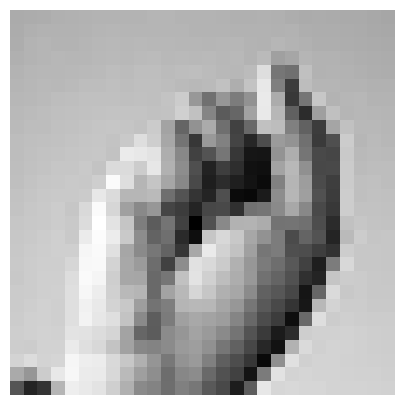

el valor predicho es: s el valor real es: s


In [32]:
idx = np.random.randint(len(y_test))
plot_letter(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es: {alphabet[y_test[idx]]}')